<center><img src="https://github.com/hse-ds/iad-applied-ds/blob/master/2021/hw/hw1/img/logo_hse.png?raw=1" width="1000"></center>

<h1><center>Прикладные задачи анализа данных</center></h1>
<h2><center>Домашнее задание 3: Прогнозирование временных рядов</center></h2>

# Введение

В этом задании Вам предстоит разобраться с основами анализа и прогнозирования временных рядов. 


![image](https://imgs.xkcd.com/comics/extrapolating.png)

In [ ]:
!pip install orbit-ml
!pip install prophet
!pip install sktime[all_extras]

In [ ]:
%matplotlib inline

from IPython import display
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')

import pandas as pd
import numpy as np

## Задание 1 (1 балл). Поиск и предобработка данных.

В этом задании Вам необходимо _самостоятельно_ найти два временных ряда: один должен обладать месячной частотой, а второй — дневной.

Мы советуем поискать соответствующие временные ряды на платформе [kaggle](https://www.kaggle.com/datasets) или же взять один из [популярных](https://medium.com/analytics-vidhya/10-time-series-datasets-for-practice-d14fec9f21bc) временных рядов для анализа. 

**Не рекомендуется** использовать в качестве временных рядов цены финансовых инструментов в силу плохой предсказуемости изменения цен. **Запрещается** использовать готовые наборы данных из библиотек для анализа временных рядов, например, `from orbit.utils.dataset import load_iclaims`.

![bitcoin](https://avatars.mds.yandex.net/get-zen_doc/3417386/pub_6017dd4b8d30cb1780864ae0_6017f4aa8d30cb1780bf66ce/scale_1200)




В качестве отчета по заданию:

* Опишите источники временных рядов (ссылки на страницы скачивания). В случае, если данные требовали дополнительной обработки, приведите код этой обработки, загрузите данные в личное облачное хранилище и приведите ссылку на скачивание. Процесс получения временных рядов должен быть **четко** расписан и полностью **воспроизводиться**. 

* Приведите код считывания временных рядов из файлов и разделения на train/test. Соотношение размеров train/test на Ваше усмотрение, но мы советуем Вам выбрать 80% на 20%, если в test остаётся хотя бы пара лет наблюдений.



In [ ]:
# Берем данные с Kaggle
# https://www.kaggle.com/datasets/aishu200023/stackindex
# https://www.kaggle.com/datasets/juliajemals/bike-sharing-washington-dc

In [ ]:
# Скачиваем с личного хранилища
!gdown --id 1liPZ8RIGK-a2oDA4TrvbA4Sw27P-NOhU
!gdown --id 1UZTLk4wbdgMpxkIRaoGZpvEuz2PUHS7p

/usr/local/lib/python3.7/dist-packages/gdown/cli.py:131: FutureWarning: Option `--id` was deprecated in version 4.3.1 and will be removed in 5.0. You don't need to pass it anymore to use a file ID.
  category=FutureWarning,
Downloading...
From: https://drive.google.com/uc?id=1liPZ8RIGK-a2oDA4TrvbA4Sw27P-NOhU
To: /content/MLTollsStackOverflow.csv
100% 30.5k/30.5k [00:00<00:00, 29.5MB/s]
/usr/local/lib/python3.7/dist-packages/gdown/cli.py:131: FutureWarning: Option `--id` was deprecated in version 4.3.1 and will be removed in 5.0. You don't need to pass it anymore to use a file ID.
  category=FutureWarning,
Downloading...
From: https://drive.google.com/uc?id=1UZTLk4wbdgMpxkIRaoGZpvEuz2PUHS7p
To: /content/bike_sharing_dataset.csv
100% 418k/418k [00:00<00:00, 10.3MB/s]


> Первый месячный временной ряд показывает количество вопросов по определенной тематике на Stackoverflow. Мы будем прогнозировать количество вопросов по теме python, как самой популярной.

> Второй дневной временной ряд показывает спрос на велопрокат в Washington DC, то есть количество клиентов. Ряд также показывает данные о погоде в тот же день. 

In [ ]:
# считаем файлы
ts1 = pd.read_csv("/content/MLTollsStackOverflow.csv")
ts2 = pd.read_csv("/content/bike_sharing_dataset.csv")

In [ ]:
ts2.index = pd.DatetimeIndex(ts2.date, freq="D")
ts2.date = pd.DatetimeIndex(ts2.date, freq="D")
ts1.index = pd.date_range(start='1/1/2009', end='1/12/2020', freq="M")
ts1.month = pd.date_range(start='1/1/2009', end='1/12/2020', freq="M")

In [ ]:
# Там где много пропусков ставим нули, где мало ставим медиану
null_cols = ts2.isna().sum()
wt_null_idx = null_cols[null_cols > 1000].index
ts2[wt_null_idx] = ts2[wt_null_idx].fillna(0)

ts2 = ts2.fillna(ts2.median())
ts1 = ts1.fillna(ts1.median())

In [ ]:
# сделаем разбиение на train/test
from sktime.forecasting.model_selection import temporal_train_test_split

ts1_train, ts1_test = temporal_train_test_split(ts1, test_size=12*2)
ts2_train, ts2_test = temporal_train_test_split(ts2, test_size=365*2)

y1_train, y1_test = temporal_train_test_split(ts1["python"], test_size=12*2)
y2_train, y2_test = temporal_train_test_split(ts2["total_cust"], test_size=365*2)

# ts1_train, ts1_test = ts1[:-26], ts1[-12*2:]
# ts2_train, ts2_test = ts2[:-365*2], ts2[-365*2:]

## Задание 2. Анализ временных рядов (1 балл).

* Отрисуйте временные ряды и визуально сделайте различимым разбиение на выборки — либо вертикальной чертой, либо разными цветами.

* Постройте графики [автокорреляционных функций](https://www.machinelearningmastery.ru/time-series-in-python-exponential-smoothing-and-arima-processes-2c67f2a52788/) для выбранных временных рядов. Прокомментируйте их: являются ли временные ряды сезонными? Видна ли на графиках длина сезонной составляющей ряда?

* В случае присутствия сезонности, разбейте временной ряд на повторяющиеся фрагменты и нарисуйте их наложенными для иллюстрации этой сезонности.

In [ ]:
# С последней версией matplotlib графики не отображались
!pip uninstall matplotlib -y
!pip install matplotlib==3.1.3

In [ ]:
import matplotlib.pyplot as plt

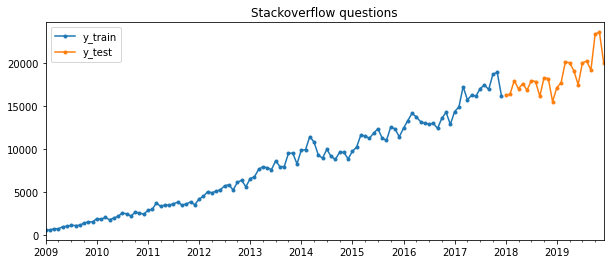

In [ ]:
# отрисуем временные ряды
fig, ax = plt.subplots(1,1, figsize=(10, 4))
y1_train.plot(ax=ax, label='y_train', style='.-')
y1_test.plot(ax=ax, label='y_test', style='.-')

plt.title("Stackoverflow questions")
plt.legend();

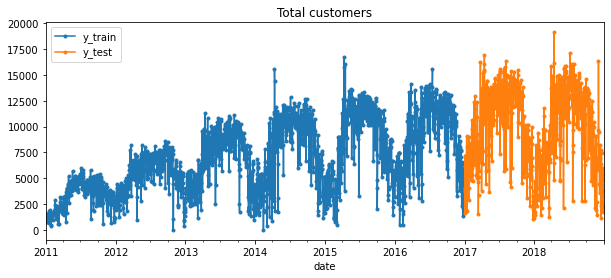

In [ ]:
fig, ax = plt.subplots(1,1, figsize=(10, 4))
y2_train.plot(ax=ax, label='y_train', style='.-')
y2_test.plot(ax=ax, label='y_test', style='.-')

plt.title("Total customers")
plt.legend();

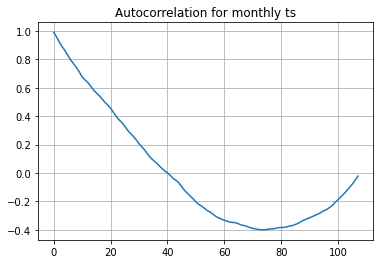

In [ ]:
# посчитайте и нарисуйте график автокорреляционной функции
centered = y1_train - y1_train.mean()
autocorr = np.correlate(centered, centered, mode='full')
autocorr = autocorr[int(autocorr.size/2):] / (y1_train.var() * y1_train.shape[0])

plt.plot(autocorr)
plt.title("Autocorrelation for monthly ts")
plt.grid();

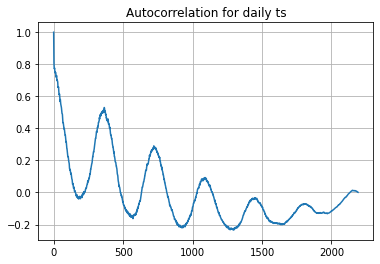

In [ ]:
centered = y2_train - y2_train.mean()
autocorr = np.correlate(centered, centered, mode='full')
autocorr = autocorr[int(autocorr.size/2):] / (y2_train.var() * y2_train.shape[0])

plt.plot(autocorr)
plt.title("Autocorrelation for daily ts")
plt.grid();

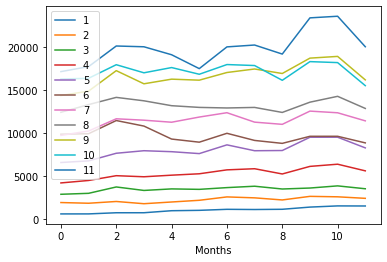

In [ ]:
# разбейте временной ряд на повторяющиеся участки по длине сезонной составляющей и нарисуйте их наложенными

for i in range(0, 132, 12):
    year = ts1.python[i:i+12].copy()
    year.index = np.arange(12)
    plt.plot(year, label=i//12+1)
plt.xlabel("Months")
plt.legend();

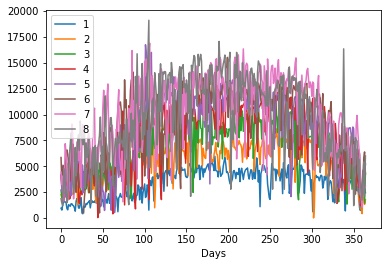

In [ ]:
for i in range(0, 2920, 365):
    year = ts2.total_cust[i:i+365].copy()
    year.index = np.arange(365)
    plt.plot(year, label=i//365+1)
plt.xlabel("Days")
plt.legend();

## Задание 3. Предсказание месячного временного ряда (4 балла).

В этом задании Вам предстоит попробовать предсказать месячный временной ряд несколькими готовыми моделями со скользящим или растущим окном и выбрать среди них наилучшую.

В качестве метрики сравнения используйте MAE между истинными и предсказанными значениями ряда на тестовом отрезке.

### NaiveForecaster из sktime (1 балл).

Посчитайте предсказания следующими двумя наивными способами:

* $\hat{y}_{t+1} = y_{t}$
* $\hat{y}_{t+1} = y_{t-seasonality+1}$

In [ ]:
# https://www.earthinversion.com/machinelearning/a-quick-look-into-the-Sktime-for-time-series-forecasting/

fh = np.arange(len(y1_test)) + 1  # forecasting horizon
def ts1_plot(y1_pred):
    fig, ax = plt.subplots(1, 1, figsize=(10, 4))
    y1_train.plot(ax=ax, label='y_train', style='.-')
    y1_test.plot(ax=ax, label='y_test', style='.-')
    y1_pred.plot(ax=ax, label='y_predict', style='.-')
    plt.legend()
    plt.grid();

MAE: 57106


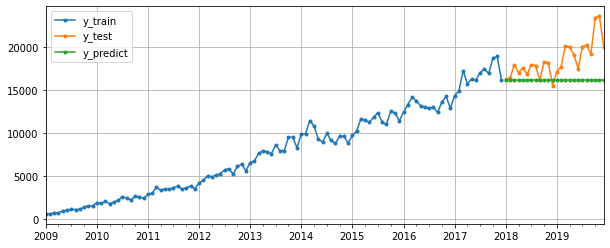

In [ ]:
from sktime.forecasting.naive import NaiveForecaster

forecaster = NaiveForecaster(strategy="last", sp=1)
forecaster.fit(y1_train)
y1_pred = forecaster.predict(fh)

print(f"MAE: {np.abs(y1_pred - y1_test).sum()}")
ts1_plot(y1_pred)

MAE: 49516.0


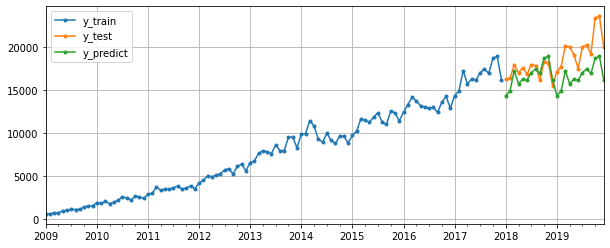

In [ ]:
forecaster = NaiveForecaster(strategy="last", sp=12)
forecaster.fit(y1_train)
y1_pred = forecaster.predict(fh)

print(f"MAE: {np.abs(y1_pred - y1_test).sum()}")
ts1_plot(y1_pred)

### ARIMA/AutoArima (1 балл).

Обучите из библиотеки `sktime` модели:

* SARIMA(1, 1, 1)(1, 0, 0)[12] (`ARIMA` в `sktime`)
* Алгоритм Хиндмана-Хандакара подбора SARIMA (`AutoARIMA` в `sktime`)

MAE: 63728.651


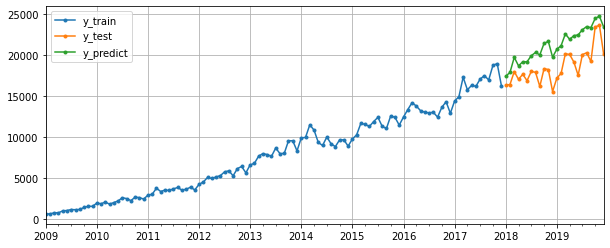

In [ ]:
from sktime.forecasting.arima import ARIMA, AutoARIMA

forecaster = ARIMA((1, 1, 1),(1, 0, 0, 12), suppress_warnings=True)
forecaster.fit(y1_train)
y1_pred = forecaster.predict(fh)

print(f"MAE: {np.abs(y1_pred - y1_test).sum():.3f}")
ts1_plot(y1_pred)

MAE: 60729.569


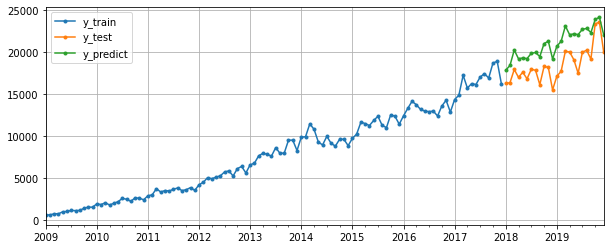

In [ ]:
forecaster = AutoARIMA(sp=12, suppress_warnings=True)
forecaster.fit(y1_train)
y1_pred = forecaster.predict(fh)

print(f"MAE: {np.abs(y1_pred - y1_test).sum():.3f}")
ts1_plot(y1_pred)

### LGT/DLT (1 балл).

Обучите из библиотеки `orbit` модели LGT и DLT

In [ ]:
from orbit.models import DLT

dlt = DLT(
    response_col='python', 
    date_col='month',
    regressor_col=ts1.columns.drop(["month", "python"]),
    global_trend_option='logistic',
    level_sm_input=1,
    seasonality=12,
)
dlt.fit(df=ts1_train)
predicted_df = dlt.predict(df=ts1_test)
predicted_df.head()

,month,prediction_5,prediction,prediction_95
0,2018-01-31,16411.303972,16941.899989,17755.313855
1,2018-02-28,16672.601973,17469.104303,18398.566994
2,2018-03-31,19187.031228,20120.966918,21223.071884
3,2018-04-30,18082.458759,18942.413227,20233.696366
4,2018-05-31,18939.714470,19918.319817,21126.407656


MAE: 60204.515065344094


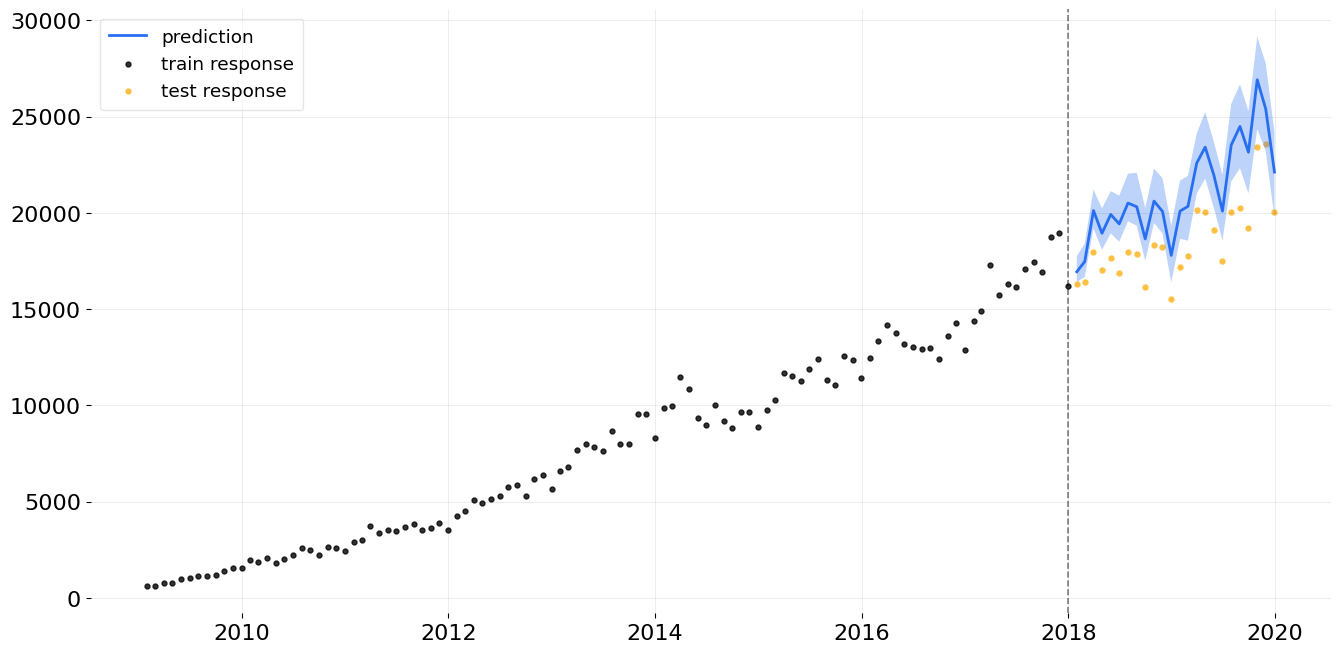

In [ ]:
from orbit.diagnostics.plot import plot_predicted_data

y1_pred = predicted_df["prediction"].values
print(f"MAE: {np.abs(y1_pred - y1_test).sum()}")

plot_predicted_data(
    training_actual_df=ts1_train, predicted_df=predicted_df,
    date_col=dlt.date_col, actual_col=dlt.response_col,
    test_actual_df=ts1_test
);

In [ ]:
from orbit.models import LGT

lgt = LGT(
    response_col='python', 
    date_col='month',
    level_sm_input=0.95,
    seasonality=12,
)
lgt.fit(df=ts1_train)
predicted_df = lgt.predict(df=ts1_test)
predicted_df.head()

,month,prediction_5,prediction,prediction_95
0,2018-01-31,16034.195858,16873.532543,17921.410356
1,2018-02-28,15462.445250,16763.257864,18502.551673
2,2018-03-31,15720.731604,17359.880947,19242.605795
3,2018-04-30,14923.762220,17132.290011,19302.280247
4,2018-05-31,14944.320647,17343.104938,19449.034084


MAE: 24919.84522504502


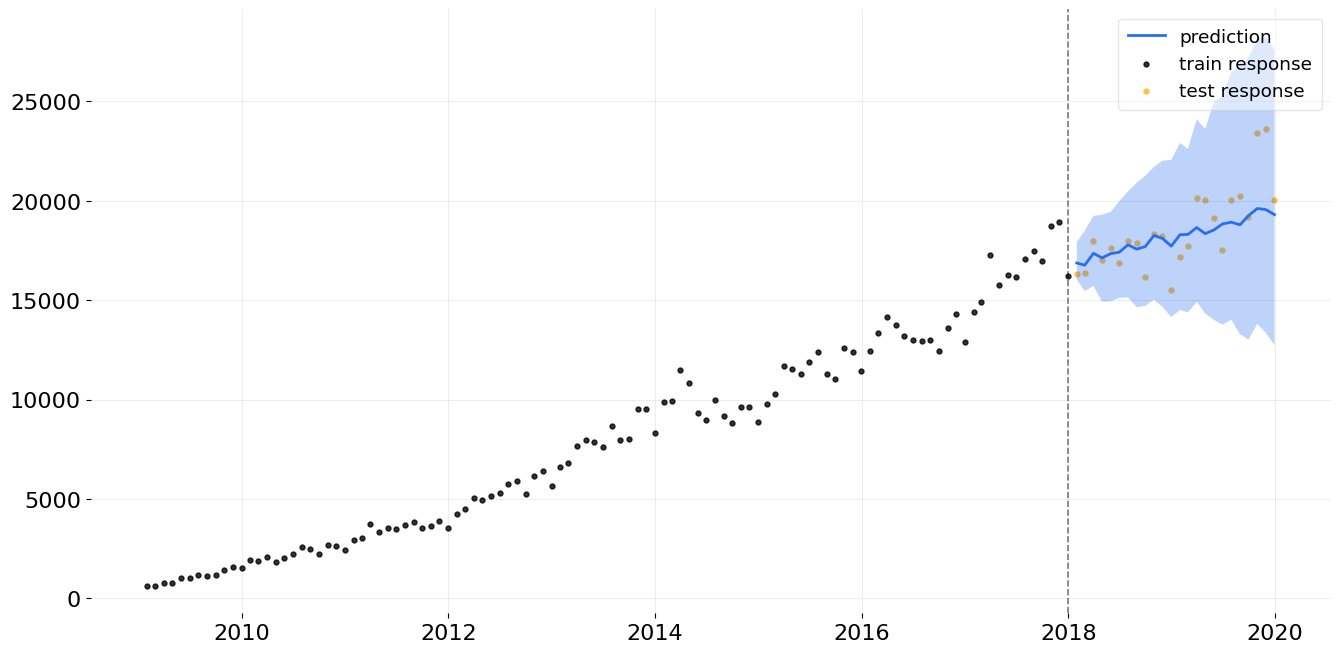

In [ ]:
y1_pred = predicted_df["prediction"].values
print(f"MAE: {np.abs(y1_pred - y1_test).sum()}")

plot_predicted_data(
    training_actual_df=ts1_train, predicted_df=predicted_df,
    date_col=lgt.date_col, actual_col=lgt.response_col,
    test_actual_df=ts1_test
);

### ETS (1 балл).

Обучите из библиотеки `sktime` модели:

* ETS(AAA) (`ExponentialSmoothing` в `sktime`)
* ETS с автоматическим выбором по AIC (`AutoETS` в `sktime`)

MAE: 52241.367082763376


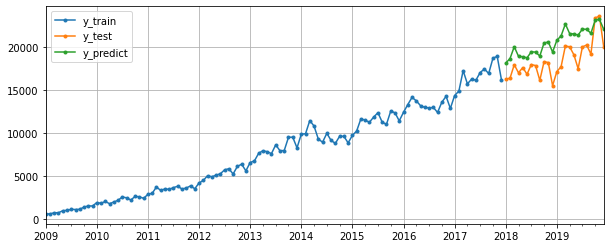

In [ ]:
from sktime.forecasting.exp_smoothing import ExponentialSmoothing

ets = ExponentialSmoothing(trend="add", damped_trend=True, seasonal="add", sp=12)
ets.fit(y1_train)
y1_pred = ets.predict(fh)

print(f"MAE: {np.abs(y1_pred - y1_test).sum()}")
ts1_plot(y1_pred)

MAE: 35611.05810454022


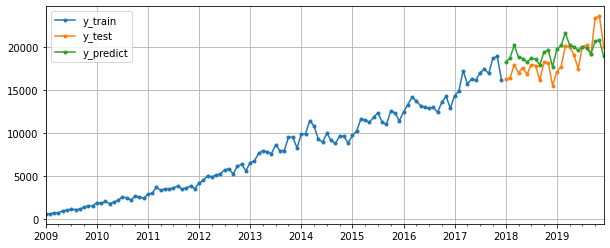

In [ ]:
from sktime.forecasting.ets import AutoETS

aets = AutoETS(trend="add", damped_trend=True, seasonal="add", sp=12)
aets.fit(y1_train)
y1_pred = aets.predict(fh)

print(f"MAE: {np.abs(y1_pred - y1_test).sum()}")
ts1_plot(y1_pred)

Нарисуйте для наилучшей модели предсказания с доверительным интервалом (если модель выдает его) и наложите их на истинные значения. В `sktime` `ETS` модель пока ещё не выдаёт доверительные интервалы, но при желании до них можно дотянуться :)

Best model - LGT with MAE: 24919.84522504502


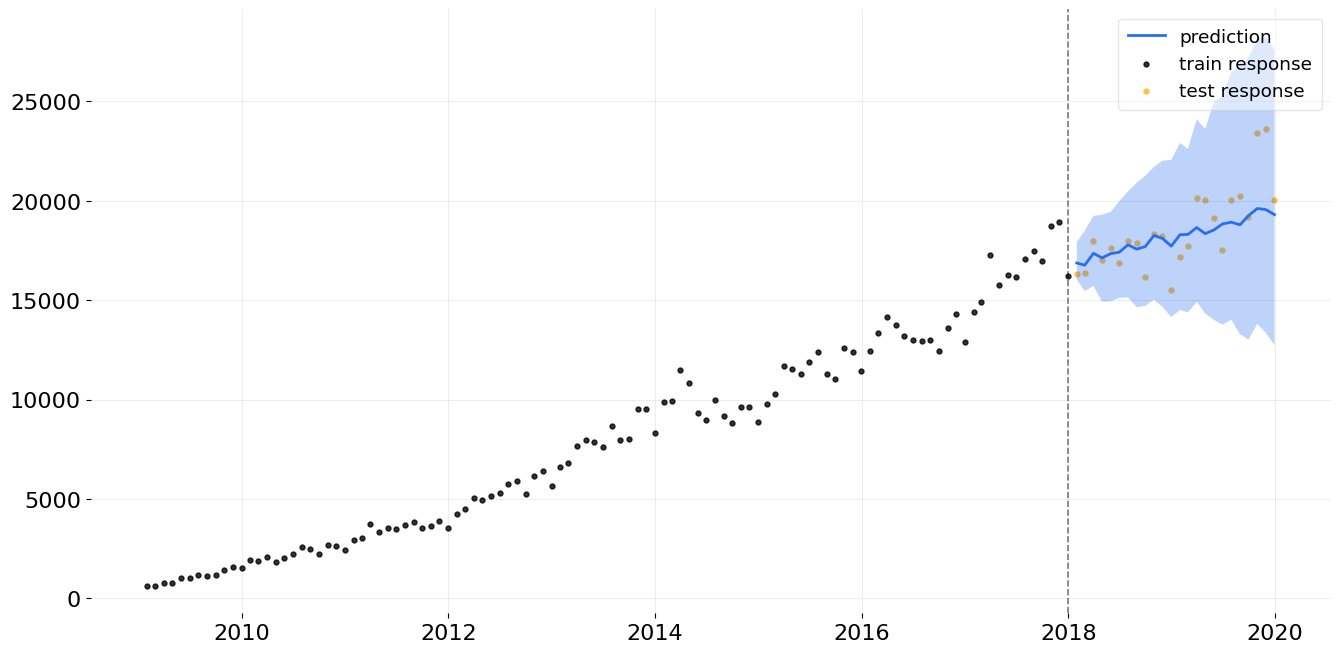

In [ ]:
y1_pred = predicted_df["prediction"].values
print(f"Best model - LGT with MAE: {np.abs(y1_pred - y1_test).sum()}")

plot_predicted_data(
    training_actual_df=ts1_train, predicted_df=predicted_df,
    date_col=dlt.date_col, actual_col=dlt.response_col,
    test_actual_df=ts1_test
);

## Задание 4. Предсказание дневного временного ряда (3 балла).

В этом задании Вам предстоит попробовать предсказать выбранный Вами дневной временной ряд.

Аналогично, в качестве метрики используем MAE.



### NaiveForecaster из sktime (1 балл).

Посчитайте предсказания следующими двумя наивными способами:

* $\hat{y}_{t+1} = y_{t}$
* $\hat{y}_{t+1} = y_{t-seasonality+1}$

In [ ]:
fh = np.arange(len(y2_test)) + 1  # forecasting horizon
def ts2_plot(y2_pred):
    fig, ax = plt.subplots(1, 1, figsize=(10, 4))
    y2_train.plot(ax=ax, label='y_train', style='.-')
    y2_test.plot(ax=ax, label='y_test', style='.-')
    y2_pred.plot(ax=ax, label='y_predict', style='.-')
    plt.legend()
    plt.grid();

MAE: 5040877.0


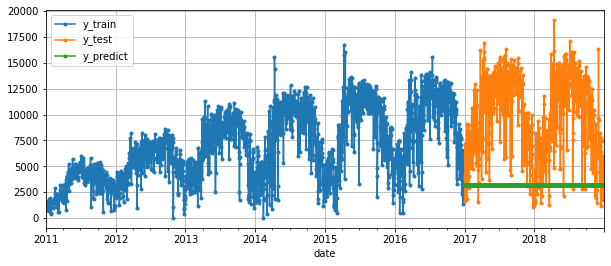

In [ ]:
from sktime.forecasting.naive import NaiveForecaster

forecaster = NaiveForecaster(strategy="last", sp=1)
forecaster.fit(y2_train)
y2_pred = forecaster.predict(fh)

print(f"MAE: {np.abs(y2_pred - y2_test).sum()}")
ts2_plot(y2_pred)

MAE: 1922855.0


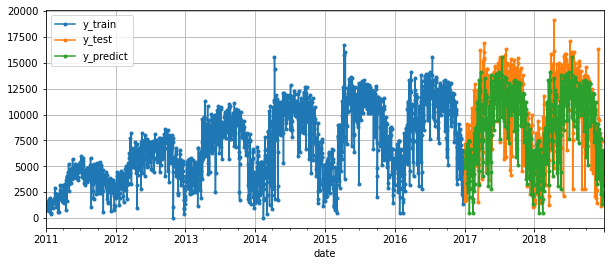

In [ ]:
forecaster = NaiveForecaster(strategy="last", sp=365)
forecaster.fit(y2_train)
y2_pred = forecaster.predict(fh)

print(f"MAE: {np.abs(y2_pred - y2_test).sum()}")
ts2_plot(y2_pred)

### KTR из orbit (1 балл).



In [ ]:
from orbit.models.ktrlite import KTRLite
from orbit.models import KTR

ktr = KTR(
    response_col='total_cust',
    date_col='date',
    seasonality=1000
)
ktr.fit(df=ts2_train)
predicted_df = ktr.predict(df=ts2_test)
predicted_df.head()

INFO:root:Guessed max_plate_nesting = 1


,date,prediction_5,prediction,prediction_95
0,2017-01-01,-4834.286780,1663.209730,6291.406455
1,2017-01-02,-5170.249997,893.064021,5886.681482
2,2017-01-03,-4078.278446,1948.699397,6147.762042
3,2017-01-04,-3687.166363,1372.594772,5850.071802
4,2017-01-05,-4803.475953,801.893967,6063.817203


MAE: 6407161.9219032265


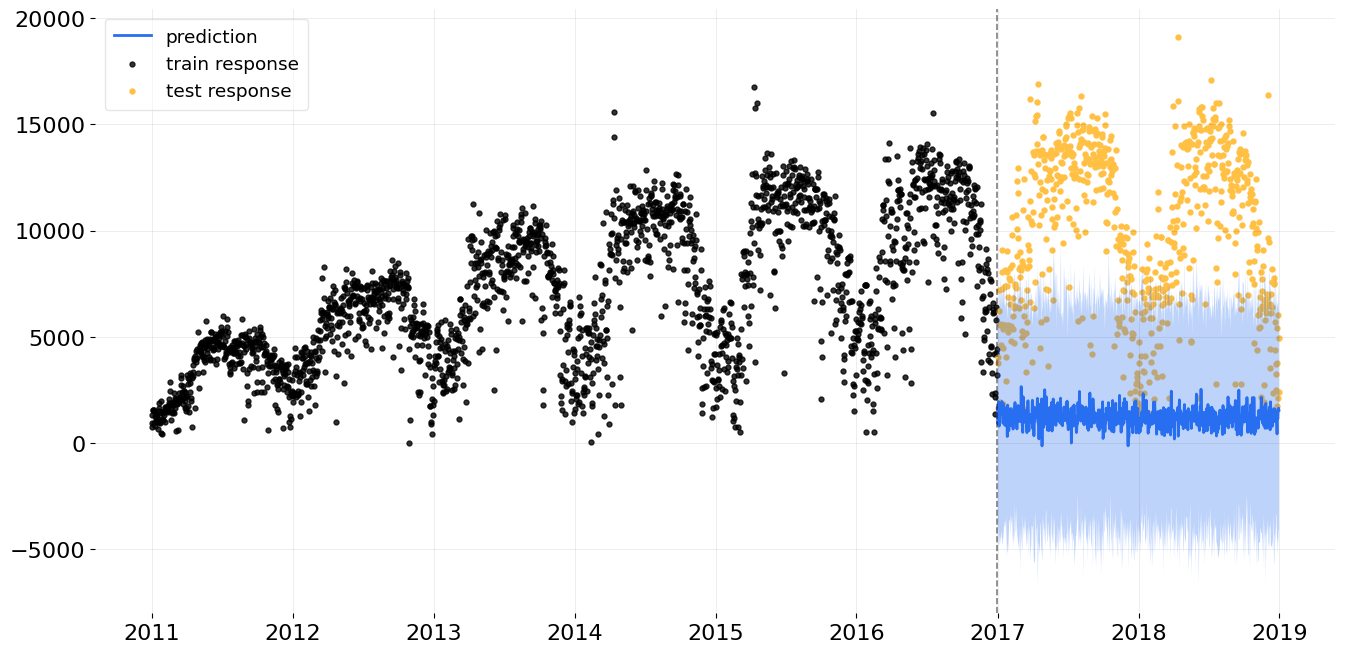

In [ ]:
y2_pred = predicted_df["prediction"].values
print(f"MAE: {np.abs(y2_pred - y2_test).sum()}")

plot_predicted_data(
    training_actual_df=ts2_train, predicted_df=predicted_df,
    date_col=ktr.date_col, actual_col=ktr.response_col,
    test_actual_df=ts2_test
);

### Phophet (1 балл).



In [ ]:
df_train = ts2_train[["date", "total_cust"]].copy()
df_train.columns = ['ds', 'y']
df_train.head()

,ds,y
date,,
2011-01-01,2011-01-01,959.0
2011-01-02,2011-01-02,781.0
2011-01-03,2011-01-03,1301.0
2011-01-04,2011-01-04,1536.0
2011-01-05,2011-01-05,1571.0


In [ ]:
from prophet import Prophet

prophet = Prophet()
prophet.fit(df_train)

future = prophet.make_future_dataframe(periods=365*2)
future.tail()

INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


,ds
2917,2018-12-27
2918,2018-12-28
2919,2018-12-29
2920,2018-12-30
2921,2018-12-31


In [ ]:
forecast = prophet.predict(future)
forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail()

,ds,yhat,yhat_lower,yhat_upper
2917,2018-12-27,7192.379691,4858.672870,9585.089530
2918,2018-12-28,7279.258039,4914.343933,9732.616458
2919,2018-12-29,7019.379268,4690.373753,9221.248194
2920,2018-12-30,6595.778633,4370.344808,9116.584901
2921,2018-12-31,6816.619048,4456.959697,9133.202453


MAE: 1568540.6224386324


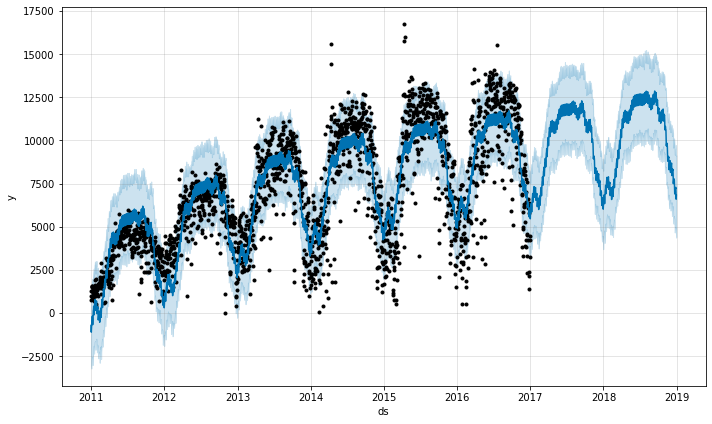

In [ ]:
y2_pred = forecast['yhat'].tail(365*2).values
print(f"MAE: {np.abs(y2_pred - y2_test).sum()}")

prophet.plot(forecast);

Нарисуйте для наилучшей модели предсказания с доверительным интервалом (если модель выдает его) и наложите их на истинные значения.

Best model - Prophet with MAE: 1568540.6224386324


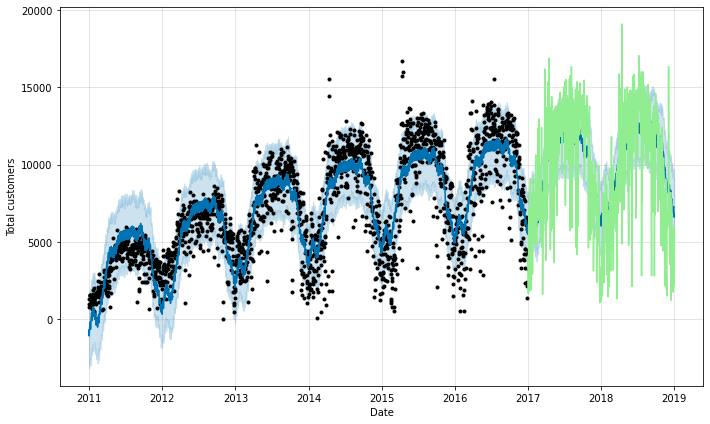

In [ ]:
y2_pred = forecast['yhat'].tail(365*2).values
print(f"Best model - Prophet with MAE: {np.abs(y2_pred - y2_test).sum()}")

prophet.plot(forecast, xlabel='Date', ylabel='Total customers')
plt.plot(y2_test, c='lightgreen');

## Задание 5. Предсказание временного ряда моделями машинного обучения (1 балл).

Возьмите один из ваших рядов, сформируйте по нему матрицу объект-признак и целевой вектор.

Разбейте данные на train/test в той же пропорции, что разбивали в заданиях выше.

Обучите различные классические модели машинного обучения и оцените их качество (MAE). 

Какая из моделей справилась с задачей предсказания лучше всего?

In [ ]:
from sklearn.model_selection import train_test_split
np.random.seed(1997)

y = ts2['total_cust']
X = ts2.drop(['total_cust', 'date', 'casual', 'registered'], axis=1)
size = 365 * 2
X_train, X_test, y_train, y_test  = X[:-size], X[-size:], y[:-size], y[-size:]

In [ ]:
from sklearn.linear_model import LinearRegression, Ridge, Lasso

model = LinearRegression()
model.fit(X_train, y_train)

y_pred = model.predict(X_test)
print(f"Linreg MAE: {np.abs(y_pred - y_test).sum()}")

Linreg MAE: 2129370.705120951


In [ ]:
model = Ridge(alpha=10000)
model.fit(X_train, y_train)

y_pred = model.predict(X_test)
print(f"Ridge MAE: {np.abs(y_pred - y_test).sum()}")

Ridge MAE: 2523385.911128409


Lasso MAE: 2223998.570783498


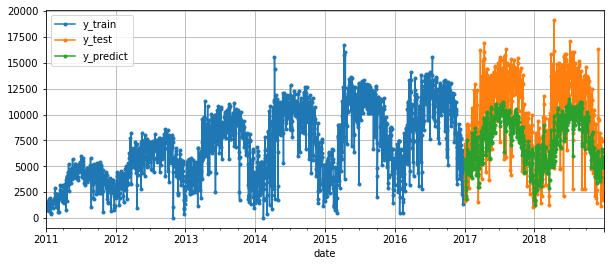

In [ ]:
model = Lasso(alpha=100)
model.fit(X_train, y_train)

y_pred = model.predict(X_test)
print(f"Lasso MAE: {np.abs(y_pred - y_test).sum()}")
ts2_plot(pd.Series(y_pred, index=y2_test.index))

LGBM MAE: 1787328.0546795754


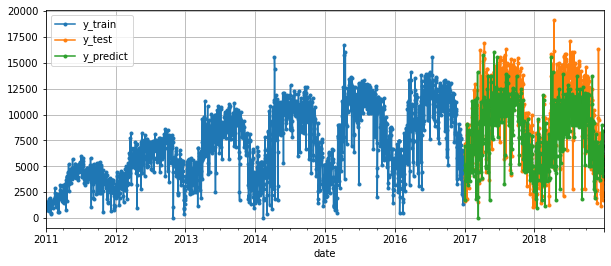

In [ ]:
from sklearn.tree import DecisionTreeRegressor

# Обучение решающего дерева глубины 1 и получение предсказаний на обучающей выборке
dt = DecisionTreeRegressor(max_depth=10)
dt.fit(X_train, y_train)

y_pred = dt.predict(X_test)
print(f"LGBM MAE: {np.abs(y_pred - y_test).sum()}")
ts2_plot(pd.Series(y_pred, index=y2_test.index))

Random Forest MAE: 1665591.1549999998


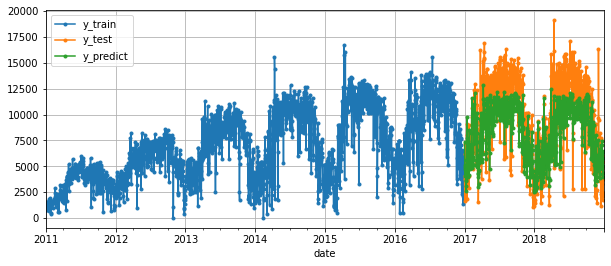

In [ ]:
from sklearn.ensemble import GradientBoostingRegressor, RandomForestRegressor

rf = RandomForestRegressor(n_estimators = 100, max_depth = 100)
rf.fit(X_train, y_train)

y_pred = rf.predict(X_test)
print(f"Random Forest MAE: {np.abs(y_pred - y_test).sum()}")
ts2_plot(pd.Series(y_pred, index=y2_test.index))

Gradient Boosting MAE: 1669097.8651789464


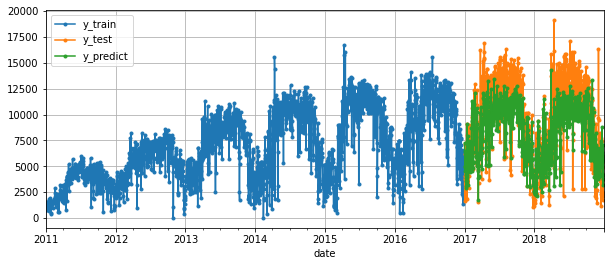

In [ ]:
gb = GradientBoostingRegressor(n_estimators = 100, max_depth = 10)
gb.fit(X_train, y_train)

y_pred = gb.predict(X_test)
print(f"Gradient Boosting MAE: {np.abs(y_pred - y_test).sum()}")
ts2_plot(pd.Series(y_pred, index=y2_test.index))

LGBM MAE: 1645995.425174303


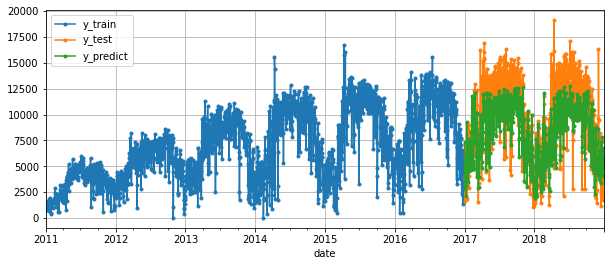

In [ ]:
import lightgbm as lgb

gbm = lgb.LGBMRegressor(num_leaves=500, n_estimators=100)
gbm.fit(X_train, y_train)

y_pred = gbm.predict(X_test, num_iteration=gbm.best_iteration_)
print(f"LGBM MAE: {np.abs(y_pred - y_test).sum()}")
ts2_plot(pd.Series(y_pred, index=y2_test.index))

Лучше всего себя показал бустинг, почти вплотную подобравшись к Prophet по метрике MAE. \
* Prophet MAE = 1568540.622 \
* Boosting MAE = 1645995.425

## Бонус. Напишите свою модель на STAN (3 балла).

Разработайте и испытайте свою модель для месячного ряда в STAN.

Сравните качество прогнозов с наивной сезонной моделью на тестовой выборке с помощью MAE. 

Комментарий: итоговый балл за домашнее задание ставится по формуле минимум(10, ваш суммарный балл за задания).

In [ ]:
# ваш код модели на STAN и её обучения здесь

In [ ]:
# посчитайте метрики на test

In [ ]:
# нарисуйте предсказания